# Manifold Learning

While PCA is flexible, fast, and easily interpretable, it does not perform so well when there are nonlinear relationships within the data.

To address this deficiency, we can turn to a class of methods known as manifold learning — a class of unsupervised estimators that seeks to describe datasets as lowdimensional manifolds embedded in high-dimensional spaces. When you think of a manifold, I’d suggest imagining a sheet of paper: this is a two-dimensional object that lives in our familiar three-imensional world, and can be bent or rolled in two dimensions. In the parlance of manifold learning, we can think of this sheet as a twodimensional manifold embedded in three-dimensional space. Rotating, reorienting, or stretching the piece of paper in three-dimensional space doesn’t change the flat geometry of the paper: such operations are akin to linear embeddings. If you bend, curl, or crumple the paper, it is still a two-dimensional manifold, but the embedding into the three-dimensional space is no longer linear. Manifold learning algorithms would seek to learn about the fundamental twodimensional nature of the paper, even as it is contorted to fill the three-dimensional space.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import numpy as np

In [2]:
# Manifold example - creating "HELLO"

def make_hello(N=1000, rseed=42):
    # make a plot with "HELLO", save as PNG
    fig, ax = plt.subplots(figsize=(4, 1))
    fig.subplots_adjust(left=0, right=1, bottom=0, top=1)
    ax.axis('off')
    ax.text(0.5, 0.4, 'HELLO', va='center', ha='center', weight='bold', size=85)
    fig.savefig('hello.png')
    plt.close(fig)
    
    # open this PNG and draw random points from it
    from matplotlib.image import imread
    data = imread('hello.png')[::-1, :, 0].T
    rng = np.random.RandomState(rseed)
    X = rng.rand(4 * N, 2)
    i, j = (X * data.shape).astype(int).T
    mask = (data[i, j] < 1)
    X = X[mask]
    X[:, 0] *= (data.shape[0] / data.shape[1])
    X = X[:N]
    return X[np.argsort(X[:, 0])]

(-0.20958628725849313,
 4.20520327441312,
 0.004247488586063178,
 1.0154103562523111)

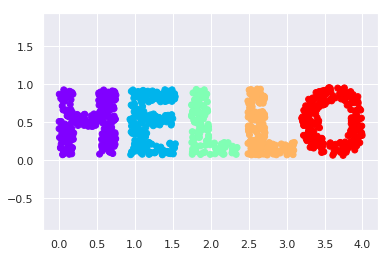

In [3]:
X = make_hello(1000)
colorize = dict(c=X[:, 0], cmap=plt.cm.get_cmap('rainbow', 5))
plt.scatter(X[:, 0], X[:, 1], **colorize)
plt.axis('equal')

### Multidimensional Scaling (MDS)

Looking at data like this, we can see that the particular choice of x and y values of the
dataset are not the most fundamental description of the data: we can scale, shrink, or rotate the data, and the “HELLO” will still be apparent. For example, if we use a rotation matrix to rotate the data, the x and y values change, but the data is still fundamentally the same.

(4.497729497784161, 8.853279087512565, 4.963846684164707, 7.303151720409396)

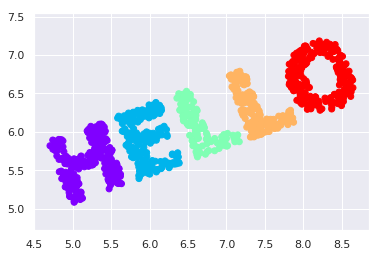

In [4]:
def rotate(X, angle):
    theta = np.deg2rad(angle)
    R = [[np.cos(theta), np.sin(theta)],
         [-np.sin(theta), np.cos(theta)]]
    return np.dot(X, R)

X2 = rotate(X, 20) + 5
plt.scatter(X2[:, 0], X2[:, 1], **colorize)
plt.axis('equal')

This tells us that the x and y values are not necessarily fundamental to the relationships in the data. What is fundamental, in this case, is the distance between each point and the other points in the dataset. A common way to represent this is to use a distance matrix: for N points, we construct an N × N array such that entry i, j contains the distance between point i and point j. 

In [5]:
from sklearn.metrics import pairwise_distances
D = pairwise_distances(X)
D.shape

(1000, 1000)

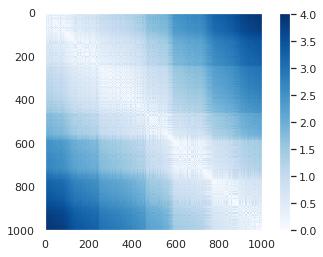

In [6]:
plt.imshow(D, zorder=2, cmap='Blues', interpolation='nearest')
plt.colorbar()

In [7]:
# If we similarly construct a distance matrix for our rotated and translated data, we see
# that it is the same

D2 = pairwise_distances(X2)
np.allclose(D, D2)

True

This distance matrix gives us a representation of our data that is invariant to rotations
and translations, but the visualization of the matrix is not entirely intuitive. Further, while computing this distance matrix from the (x, y) coordinates is straightforward, transforming the distances back into x and y coordinates is rather difficult. This is exactly what the multidimensional scaling algorithm aims to do: given a distance matrix between points, it recovers a D-dimensional coordinate representation of the data. Let’s see how it works for our distance matrix, using the precomputed dissimilarity to specify that we are passing a distance matrix.

(-2.0702232396136884,
 2.130799170163769,
 -1.3777423146785437,
 1.3776009759914727)

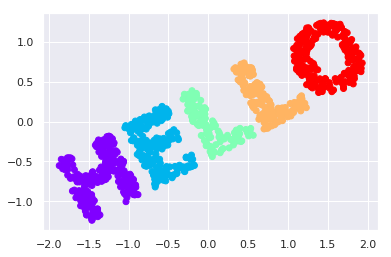

In [8]:
from sklearn.manifold import MDS

model = MDS(n_components=2, dissimilarity='precomputed', random_state=1)
out = model.fit_transform(D)
plt.scatter(out[:, 0], out[:, 1], **colorize)
plt.axis('equal')

The MDS algorithm recovers one of the possible two-dimensional coordinate repre‐
sentations of our data, using only the N × N distance matrix describing the relation‐
ship between the data points.

### MDS as Manifold Learning

The usefulness of this becomes more apparent when we consider the fact that distance matrices can be computed from data in any dimension. So, for example, instead of simply rotating the data in the two-dimensional plane, we can project it into three dimensions using the following function (essentially a three-dimensional generalization of the rotation matrix used earlier).

In [9]:
def random_projection(X, dimension=3, rseed=42):
    assert dimension >= X.shape[1]
    rng = np.random.RandomState(rseed)
    C = rng.randn(dimension, dimension)
    e, V = np.linalg.eigh(np.dot(C, C.T))
    return np.dot(X, V[:X.shape[1]])

X3 = random_projection(X, 3)
X3.shape

(1000, 3)

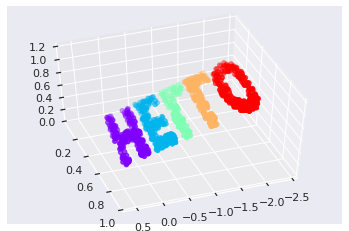

In [10]:
# data visualization

from mpl_toolkits import mplot3d

ax = plt.axes(projection='3d')
ax.scatter3D(X3[:, 0], X[:, 1], X3[:, 2],
             **colorize)
ax.view_init(azim=70, elev=50)

We can now ask the MDS estimator to input this three-dimensional data, compute the distance matrix, and then determine the optimal two-dimensional embedding for this distance matrix. The result recovers a representation of the original data.

(-2.070223239613712,
 2.1307991701642517,
 -1.3777423146786878,
 1.3776009759950083)

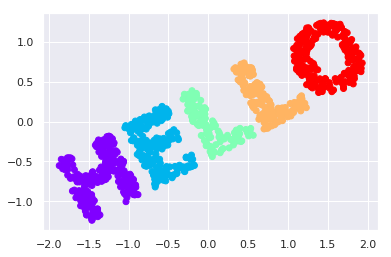

In [11]:
model = MDS(n_components=2, random_state=1)
out3 = model.fit_transform(X3)
plt.scatter(out3[:, 0], out3[:, 1], **colorize)
plt.axis('equal')

This is essentially the goal of a manifold learning estimator: given high-dimensional embedded data, it seeks a low-dimensional representation of the data that preserves certain relationships within the data. In the case of MDS, the quantity preserved is the distance between every pair of points.

### Nonlinear embeddings: where MDS fails

Our discussion so far has considered linear embeddings, which essentially consist of rotations, translations, and scalings of data into higher-dimensional spaces. Where MDS breaks down is when the embedding is nonlinear—that is, when it goes beyond this simple set of operations. Consider the following embedding, which takes the input and contorts it into an “S” shape in three dimensions.

In [14]:
def make_hello_s_curve(X):
    t = (X[:, 0] - 2) * 0.75 * np.pi
    x = np.sin(t)
    y = X[:, 1]
    z = np.sign(t) * (np.cos(t) - 1)
    return np.vstack((x, y, z)).T

XS = make_hello_s_curve(X)

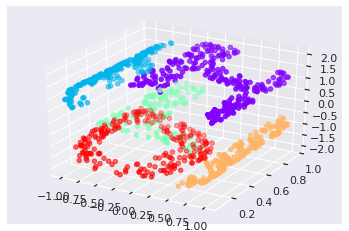

In [15]:
from mpl_toolkits import mplot3d

ax = plt.axes(projection='3d')
ax.scatter3D(XS[:, 0], XS[:, 1], XS[:, 2],
             **colorize)

The fundamental relationships between the data points are still there, but this time
the data has been transformed in a nonlinear way: it has been wrapped up into the shape of an “S". If we try a simple MDS algorithm on this data, it is not able to “unwrap” this nonlinear embedding, and we lose track of the fundamental relationships in the embedded
manifold.

(-2.137743958785904,
 1.9525966315357874,
 -1.9667872566209672,
 1.7978925909661014)

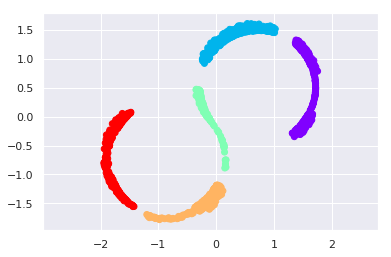

In [16]:
model = MDS(n_components=2, random_state=2)
outS = model.fit_transform(XS)
plt.scatter(outS[:, 0], outS[:, 1], **colorize)
plt.axis('equal')

The best two-dimensional linear embedding does not unwrap the S-curve, but instead throws out the original y-axis.

### Nonlinear Manifolds: Locally Linear Embedding

The source of the problem is that MDS tries to preserve distances between faraway points when constructing the embedding, so possible solution should be preserving distances only between nearby points. That is what manifold learning algorithm called locally linear embedding does. Rather than preserving all distances, it instead tries to preserve only the distances between neighboring points. We could imagine unrolling the data in a way that keeps the lengths of the lines approximately the same. This is precisely what LLE does, through a global optimization of a cost function reflecting this logic.

(0.15, -0.15)

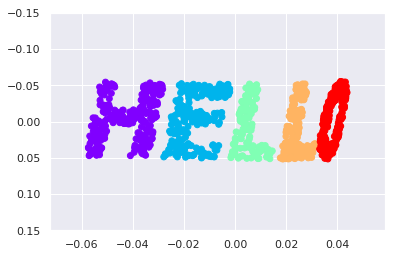

In [17]:
from sklearn.manifold import LocallyLinearEmbedding

model = LocallyLinearEmbedding(n_neighbors=100, n_components=2, method='modified',
                               eigen_solver='dense')
out = model.fit_transform(XS)

fig, ax = plt.subplots()
ax.scatter(out[:, 0], out[:, 1], ** colorize)
ax.set_ylim(0.15, -0.15)

The result remains somewhat distorted compared to our original manifold, but cap‐
tures the essential relationships in the data.

#### Aditional thoughts
Though this story and motivation is compelling, in practice manifold learning techniques tend to be finicky enough that they are rarely used for anything more than simple qualitative visualization of high-dimensional data. The following are some of the particular challenges of manifold learning, which allcontrast poorly with PCA:

• In manifold learning, there is no good framework for handling missing data. In contrast, there are straightforward iterative approaches for missing data in PCA.

• In manifold learning, the presence of noise in the data can “short-circuit” the manifold and drastically change the embedding. In contrast, PCA naturally filters noise from the most important components.

• The manifold embedding result is generally highly dependent on the number of neighbors chosen, and there is generally no solid quantitative way to choose an optimal number of neighbors. In contrast, PCA does not involve such a choice.

• In manifold learning, the globally optimal number of output dimensions is difficult to determine. In contrast, PCA lets you find the output dimension based on the explained variance.

• In manifold learning, the meaning of the embedded dimensions is not always clear. In PCA, the principal components have a very clear meaning.

• In manifold learning the computational expense of manifold methods scales as O[N^2] or O[N^3]. For PCA, there exist randomized approaches that are generally much faster (though see the megaman package for some more scalable implementations of manifold learning).

With all that on the table, the only clear advantage of manifold learning methods over PCA is their ability to preserve nonlinear relationships in the data; for that reason I tend to explore data with manifold methods only after first exploring them with PCA.

Scikit-Learn implements several common variants of manifold learning beyond Isomap and LLE: the Scikit-Learn documentation has a nice discussion and comparison of them. Based on my own experience, I would give the following recommendations:

• For toy problems such as the S-curve we saw before, locally linear embedding (LLE) and its variants (especially modified LLE), perform very well. This is implemented in sklearn.manifold.LocallyLinearEmbedding.

• For high-dimensional data from real-world sources, LLE often produces poor results, and isometric mapping (Isomap) seems to generally lead to more meaningful embeddings. This is implemented in sklearn.manifold.Isomap.

• For data that is highly clustered, t-distributed stochastic neighbor embedding (tSNE) seems to work very well, though can be very slow compared to other methods. This is implemented in sklearn.manifold.TSNE.